## Estimation of memory to run PyGBe 

We want to know an estimation of the memory needs (GPU) to run bigger problem that what we've been running with PyGBe.

In this notebook we are showing some results on memory profiling obtained using **nvprof** (Nvidia profiler) for different problem sizes. 

We used a TESLA C2075 Nvidia GPU to make the runs.   


##### Estimation of number of elements for a 1M atoms protein.

Before estimating the amount of memory needed to run big problems ($>1M$), for completion, we will get an idea of how many elements (triangles) will have a mesh generated for this number of atoms. We will use the cases we've already run on and their density $d=2$ meshes generated using MSMS to do a linear regression and therefore estimate the number of elements needed. For simplicity and to have a first approach we used the meshes that doesn't involve cavities and stern layer.    

| Protein | Num. of atoms | Num. of elem. (d=2) |
|:-------:|:-------------:|:-------------------:|
|  1PGB   |      862      |         11696       |
|  1HEL   |      1323     |         21944       |
|  3BTK   |      4074     |         39432       |
|  1IGT   |      20147    |         225512      |


In [2]:
import numpy
from matplotlib import pyplot
from scipy.stats import linregress
%matplotlib inline

In [3]:
atoms = numpy.array([862,1323,4074,20147])
elements = numpy.array([11696,21944,39432,225512])

In [4]:
fit = numpy.polyfit(atoms, elements, 1)
fit_fn = numpy.poly1d(fit)

In [5]:
std_err = numpy.std(elements)
print(std_err)
fit_std_plus = fit_fn(atoms) + std_err
fit_std_minus = fit_fn(atoms) - std_err

87665.2426221


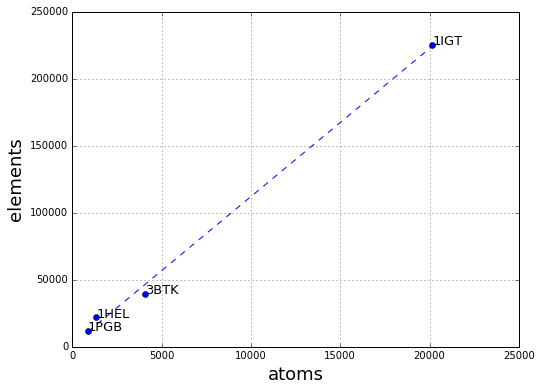

In [6]:
# Regression of number of elements according to number of atoms
pyplot.figure(figsize=(8,6))
pyplot.grid(True)

label = ['1PGB','1HEL','3BTK','1IGT']
for i, txt in enumerate(label):
    pyplot.annotate(txt, (atoms[i],elements[i]), rotation=0, fontsize=13)

pyplot.xlabel('atoms', fontsize=18)
pyplot.ylabel('elements', fontsize=18)
#pyplot.plot(atoms, fit_std_plus, '--r', label='$\sigma_{err}$')
#pyplot.plot(atoms,fit_std_minus, '--r')
#pyplot.annotate('$+\sigma_{err}$', (atoms[3],fit_std_plus[3]), fontsize=16)
#pyplot.annotate('$-\sigma_{err}$', (atoms[3],fit_std_minus[3]), fontsize=16);
pyplot.plot(atoms,elements, 'ob', atoms, fit_fn(atoms), '--b');



In [7]:
#estimate of elements for 1 and 3 million atoms according to the regression
elem_1Ma = fit_fn(1000000)
elem_dengue = fit_fn(1082160)
elem_3Ma = fit_fn(3000000)


print ('for 1M atoms: {:f} elements'.format(elem_1Ma))
print ('for dengue virus: {:f} elements'.format(elem_dengue))
print ('for 3M atoms: {:f} elements'.format(elem_3Ma))


for 1M atoms: 11060054.922977 elements
for dengue virus: 11968613.972655 elements
for 3M atoms: 33176876.969673 elements


According to the regression, the amount of elements on a mesh of density $d=2$ on MSMS for a 1 million atoms protein and for a 3 million atoms protein are approximately 11 and 33 millions respectively. Let's remember that this estimations do not include cavities or stern layer, what will increase the number of elements, but there is no way to estimate how much they will increase because the amount of cavities is strongly dependent on the protein. 

##### Estimation of memory 

We show the memory required to run `PyGBe` for all the cases of proteins we have. First we show for 1 iteration and then a progression for 1, 2, 4, 8, 16 and total iterations for each protein. 

*Note*: HtoD stands for Host to Device and DtoH for Device to Host.

*Parameters used*

**K**: 1             (number of Gauss points per element). 

**Nk**: 9        (number of Gauss points per side for semi-analytical
                 integration).

**K_fine**: 19 (Number of Gauss points per element for near singular integrals).

**threshold**: 0.5   (defines region near singularity where semi-analytical technique is used). 
                
**BSZ**: 128         (CUDA block size).

**tolerance**: 1e-5  (GMRES tolerance).

**P**: 4             (order of expansion in treecode).

**eps**: 1e-12       (epsilon machine).

**NCRIT**: 500       (maximum number of boundary elements per twig box of tree structure).

**theta**: 0.5       (multipole acceptance criterion of treecode).


**Iteration number 1**

| Protein | Mem HtoD (MB) | Mem DtoH (MB)|
|:-------:|:-------------:|:------------:|
|  1PGB   |      18.51    |     4.356    |
|  1HEL   |      24.84    |     4.796    |
|  3BTK   |      71.752   |     13.376   |
|  1IGT   |      639.406  |     70.796   |


In [8]:
#Linear regressions for 1 iteretation Hto D and DtoH
HtoD_1it = numpy.array([18.51, 24.84, 71.752, 639.406])
DtoH_1it = numpy.array([4.356, 4.796, 13.376, 70.796])

fit_HtoD_1it = numpy.polyfit(atoms, HtoD_1it, 1)
fn_HtoD_1it = numpy.poly1d(fit_HtoD_1it)

fit_DtoH_1it = numpy.polyfit(atoms, DtoH_1it, 1)
fn_DtoH_1it = numpy.poly1d(fit_DtoH_1it)

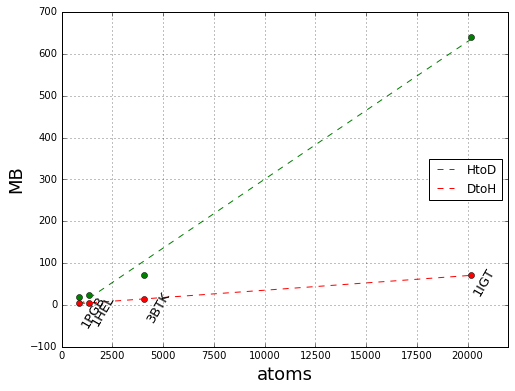

In [9]:
# Memory requirements for 1 iteration according to number of atoms 
pyplot.figure(figsize=(8,6))
pyplot.grid(True)

label = ['1PGB','1HEL','3BTK','1IGT']
for i, txt in enumerate(label):
    pyplot.annotate(txt, (atoms[i],DtoH_1it[i]), rotation=60, fontsize=13)


pyplot.xlim(0, 22000)
pyplot.xticks(numpy.arange(0, 22000, 2500))
pyplot.xlabel('atoms', fontsize=18)
pyplot.ylabel('MB', fontsize=18)
pyplot.plot(atoms,HtoD_1it, 'og')
pyplot.plot(atoms, fn_HtoD_1it(atoms), '--g', label= 'HtoD')
pyplot.plot(atoms,DtoH_1it, 'or')
pyplot.plot(atoms, fn_DtoH_1it(atoms), '--r', label= 'DtoH');
pyplot.legend(loc='center right');


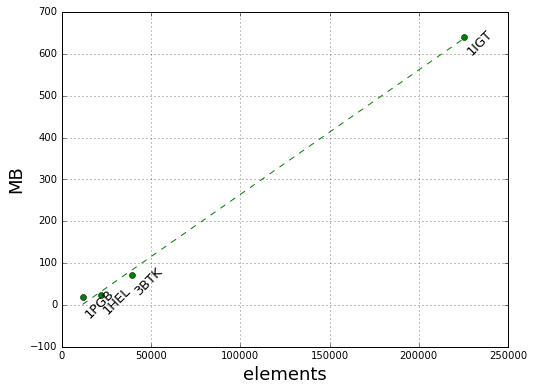

In [18]:
#In terms of elements, the HtoD mem.

fit_HtoD_1it_e = numpy.polyfit(elements, HtoD_1it, 1)
fn_HtoD_1it_e = numpy.poly1d(fit_HtoD_1it_e)


pyplot.figure(figsize=(8,6))
pyplot.grid(True)

label = ['1PGB','1HEL','3BTK','1IGT']
for i, txt in enumerate(label):
    pyplot.annotate(txt, (elements[i], HtoD_1it[i]), rotation=45, fontsize=13)

pyplot.ylim(-100, 700)
pyplot.xlabel('elements', fontsize=18)
pyplot.ylabel('MB', fontsize=18)
pyplot.plot(elements, HtoD_1it, 'og')
pyplot.plot(elements, fn_HtoD_1it_e(elements), '--g', label= 'HtoD');

Let's use these linear regressions to have an estimation of how much memory do we need to run bigger problems. 

In [11]:
#Memory estimation for 1M atoms
mem_1M_HtoD = fn_HtoD_1it(1000000)
mem_1M_DtoH = fn_DtoH_1it(1000000)
print('The memory (HtoD) needed to run a 1M atoms protein is approx. {:f} GB'.format(mem_1M_HtoD/1000))
print('The memory (DtoH) needed to run a 1M atoms protein is approx. {:f} GB'.format(mem_1M_DtoH/1000))

The memory (HtoD) needed to run a 1M atoms protein is approx. 32.852474 GB
The memory (DtoH) needed to run a 1M atoms protein is approx. 3.490263 GB


In [19]:
#Memory estimation for the corresponding elements (~11060055) HtoD
mem_11Me_HtoD = fn_HtoD_1it_e(11060055)
print('The memory (HtoD) needed to run order of 11M elements is approx. {:f} GB'.format(mem_11Me_HtoD/1000))


The memory (HtoD) needed to run order of 11M elements is approx. 32.873725 GB


The NVIDIA cards we have available now on our lab have these memory specifications:

| CARD    |    Mem (GB)   |
|:-------:|:-------------:|
|  C2075  |      5.6      |
|  K20    |      4.9      |
|  K40    |      11.99    |





Looking at these numbers let's compute the biggest amount of atoms that we can run in each card. 

In [20]:
#Maxium of atoms per card for HtoD memory.

#We multiply for 1000 because m and b are in MB.
card_mem = numpy.array([5.6, 4.9, 11.99]) * 1000  
m , b = fit_HtoD_1it[0] , fit_HtoD_1it[1]
m_e , b_e = fit_HtoD_1it_e[0] , fit_HtoD_1it_e[1]

atoms_max = (card_mem - b)/m
elements_max = (card_mem - b_e)/m_e

print('Maxium amount of atoms allow on a:')
print('C2075 is approx {:.0f}'.format(atoms_max[0]))
print('K20 is approx {:.0f}'.format(atoms_max[1]))
print('K40 is approx {:.0f}'.format(atoms_max[2]))
print('------------------------------------------')
print('Maxium amount of elements allow on a:')
print('C2075 is approx {:.0f}'.format(elements_max[0]))
print('K20 is approx {:.0f}'.format(elements_max[1]))
print('K40 is approx {:.0f}'.format(elements_max[2]))

Maxium amount of atoms allow on a:
C2075 is approx 171176
K20 is approx 149887
K40 is approx 365514
------------------------------------------
Maxium amount of elements allow on a:
C2075 is approx 1893400
K20 is approx 1658131
K40 is approx 4041069


We have to have in mind that these numbers were calculated for the simplest geometry that one cna obtain from the meshing tool. If we include cavities the amount of elements will be bigger for the same amount of atoms. Another consideration is that these number depends on the treecode parameters, for a $1M$ atoms protein having $NCRIT=500$ might not be the best choice. The order of expansion taylor expansion $P$, will also imply a variation on the memory requirements.

Until now we've been using MSMS to generate the meshes for our proteins, this will be an inconvinient for bigger problems. Chen and Lu in their paper about TMSmesh [Chen&Lu2010](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.710.5779&rep=rep1&type=pdf) talk about the MSMS crushing for some problems bigger than 150000 atoms. Therefore, in the case we are available to run big problems, we will need to find a different mesh generator.   

In [14]:
from IPython.core.display import HTML
def css_styling():
    styles = open('styles/custom.css', 'r').read()
    return HTML(styles)
css_styling()